# About this notebook

## Version1
- PyTorch lstm starter code
- 60 epochs
- batch size 32 no accumulation
- AdamW optimizer
- No weight initialization
- No categorical features are used

## Version2
- PyTorch lstm starter code
- 60 epochs
- batch size 32 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- Data normalization is used

## Version3
- PyTorch lstm starter code
- 60 epochs
- batch size 32 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- No data normalization is used

## Version4
- PyTorch lstm starter code
- 60 epochs
- batch size 32 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- No data normalization is used
- `num_layer = 2`

## Version5
- PyTorch lstm starter code
- 60 epochs
- batch size 64 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- No data normalization is used
- `num_layer = 3`

## Version6
- PyTorch lstm starter code
- 60 epochs
- batch size 32 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- No data normalization is used
- `num_layer = 3`
- Hubber loss function

## Version7
- PyTorch lstm starter code
- 60 epochs
- batch size 32 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- No data normalization is used
- `num_layer = 3`
- sequence length 120

## Version8
- PyTorch lstm starter code
- 60 epochs
- batch size 64 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- No data normalization is used
- `num_layer = 3`
- sequence length 2
- lr = 1e-3

## Version9
- PyTorch lstm starter code
- 60 epochs
- batch size 64 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- No data normalization is used
- `num_layer = 2`
- sequence length 2
- lr = 1e-3
- eta_min = 1e-4*0.5

## Version10
- PyTorch lstm starter code
- 60 epochs
- batch size 64 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- No data normalization is used
- `num_layer = 2`
- sequence length 21
- lr = 1e-3
- eta_min = 1e-4*0.5

## Version11
- PyTorch lstm starter code
- 60 epochs
- batch size 64 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- No data normalization is used
- `num_layer = 3`
- sequence length 48
- lr = 1e-3
- eta_min = 1e-4*0.5
- add feature engineering: diff by 1

# Library

In [1]:
import os
import random
from tqdm.auto import tqdm
import time
import wandb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW

from torch.optim.lr_scheduler import (CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau,
OneCycleLR)
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

DIR = './'
if not os.path.exists(DIR):
    os.mkdir(DIR)

device=("cuda" if torch.cuda.is_available() else "cpu")
VERSION=11

# Load data

In [2]:
data = pd.read_csv('../input/beijing-air-quality-preprocessed/airquality_data.csv')
FEATURES_COLUMNS = [col for col in data.columns if col not in ['No', 'year', 'month', 'day', 'hour']]

# Configuration

In [3]:
class CFG:
    apex=False
    debug=False
    kaggle = True
    print_freq=2000
    num_workers=1
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=60
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':6,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':5,
        'eta_min':1e-4,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3
    }
    batch_size=32 #64
    lr=1e-4
    weight_decay=1e-2
    gradient_accumulation_steps=1
    max_grad_norm=1000 # Gradient clipping to prevent exploding / vanishing gradient 
    target_size=1
    num_layers=3
    input_size=len(FEATURES_COLUMNS)
    hidden_size=100
    seq_length=48 # 48h
    nfolds=5
    trn_folds=[0, 1, 2, 3, 4]
    target_col="PM2.5"
    model_name="lstm_network"
    group = 'lstm'
    train=True
    seed=42
    
if CFG.debug:
    CFG.epochs=2
    data=data.sample(n=10000, random_state=CFG.seed).reset_index(drop=True).fillna(method="ffill")

# Data Preprocessing

# Train test split

In [4]:
train_data, test = train_test_split(data,
                               test_size=0.1,
                               shuffle=False)

In [5]:
train, valid = train_test_split(train_data,
                               test_size=0.1,
                               shuffle=False)

# Utils

In [6]:
def get_score(y_true, y_pred):
    score = math.sqrt(mse(y_true, y_pred))
    return score

def init_logger(log_file=DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(seed=45)

def rolling_window(data_df, window=1):
    
    rolling_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour', 'PM2.5']]].rolling(window).mean().fillna(0)
    rolling_df.columns = [col+"_"+f"rolling_{window}" for col in rolling_df.columns]
    
    return rolling_df

def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):
    
    sequences = []
    data_size = input_data.shape[0]
    for i in tqdm(range(data_size - sequence_length)):
        
        sequence = input_data[i: i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]
        sequences.append((sequence[[col for col in sequence.columns if col not in ['No']]], label))
        
    return sequences

def diff_data(data_df, diff=1):
    
    diff_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour']]].diff(diff).fillna(0)
    diff_df.columns = [col+"_"+f"diff_{diff}" for col in diff_df.columns]
    
    return diff_df

# Feature engineering

In [7]:
train_diff = diff_data(train, diff=1)
train = pd.concat([train, train_diff], axis=1)

valid_diff = diff_data(valid, diff=1)
valid = pd.concat([valid, valid_diff], axis=1)

test_diff = diff_data(test, diff=1)
test = pd.concat([test, test_diff], axis=1)

FEATURES_COLUMNS = [col for col in train.columns if col not in ['No']]
CFG.input_size = len(FEATURES_COLUMNS)

### Create sequences from  data

In [8]:
%%time
train_sequence = create_sequences(train, CFG.target_col, CFG.seq_length)
valid_sequence = create_sequences(valid, CFG.target_col, CFG.seq_length)
test_sequence = create_sequences(test, CFG.target_col, CFG.seq_length)

  0%|          | 0/325268 [00:00<?, ?it/s]

  0%|          | 0/36099 [00:00<?, ?it/s]

  0%|          | 0/40115 [00:00<?, ?it/s]

CPU times: user 6min 23s, sys: 7.8 s, total: 6min 31s
Wall time: 6min 32s


# Pytorch Dataset

In [9]:
class AirQualityDataset(Dataset):
    
    def __init__(self, sequences):
        
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        
        sequence, target = self.sequences[idx]
        
        return torch.tensor(sequence.to_numpy()).float(), torch.tensor(target).float()

In [10]:
train_dataset = AirQualityDataset(train_sequence)
sequence, label = train_dataset[0]
print(f'sequence shape: {sequence.shape}')
print(f'label shape: {label.shape}')

sequence shape: torch.Size([48, 28])
label shape: torch.Size([])


# W&B

In [11]:
if CFG.kaggle:
    
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    wandb_api = user_secrets.get_secret("wandb_key")

    wandb.login(key=wandb_api)

else:
    
    wandb.login()

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Baijing airquality prediction", 
                 name=CFG.model_name,
                 config=class2dict(CFG),
                 group=CFG.group,
                 tags=[f'CFG.model_name_version{VERSION}'],
                 job_type="train")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: djoe. Use `wandb login --relogin` to force relogin


# Model

In [12]:
class LSTM(nn.Module):

    def __init__(
                 self, 
                 target_size=CFG.target_size,
                 input_size=CFG.input_size, 
                 hidden_size=CFG.hidden_size,
                 num_layers=CFG.num_layers
                 ):
        
        super(LSTM, self).__init__()
        
        self.target_size = CFG.target_size
        self.num_layers = CFG.num_layers
        self.input_size = CFG.input_size
        self.hidden_size = CFG.hidden_size
        self.seq_length = CFG.seq_length
        
        self.lstm = nn.LSTM(
                            input_size=self.input_size, # Features of the sequence
                            hidden_size=self.hidden_size, # Hidden units for the lstm
                            num_layers=self.num_layers, # Number of layers
                            batch_first=True, # (batch, seq, features)
                            dropout=0.2,
                            bidirectional=True
                           )
        
        self.fc = nn.Linear(self.hidden_size, self.target_size)
        
        
    def forward(self, x):
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x)
        
        h_out = h_out[-1]
        
        out = self.fc(h_out)
        
        return out

# Helper Functions

In [13]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (sequences, targets) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        #num = dct['num_data'].to(device)
        #cat = dct['cat_data'].to(device)
        sequences = sequences.to(device)
        targets = targets.to(device)
        batch_size = targets.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(sequences)
                loss = criterion(y_preds.squeeze(1), targets)
        else:
            y_preds = model(sequences)
            loss = criterion(y_preds.squeeze(1), targets)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_last_lr()[0]))
        if fold:
            
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_last_lr()[0]})
        else:
            
            wandb.log({"loss": losses.val,
                       "lr": scheduler.get_last_lr()[0]})
            
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    targets_list = []
    start = end = time.time()
    for step, (sequences, targets) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        #num = dct['num_data'].to(device)
        #cat = dct['cat_data'].to(device)
        sequences = sequences.to(device)
        targets = targets.to(device)
        batch_size = targets.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(sequences)
        preds.append(y_preds.detach().to('cpu').numpy())
        targets_list.append(targets.detach().to('cpu').numpy())
        
        loss = criterion(y_preds.squeeze(1), targets)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    targets = np.concatenate(targets_list)
    return losses.avg, predictions, targets

# ====================================================
# inference
# ====================================================
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    forcasts = []
    targets_list = []
    for i, (sequences, targets) in enumerate(tk0):
        sequences = sequences.to(device).float()
        targets = targets.to(device).float()
        avg_forcasts = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(sequences)
            avg_forcasts.append(y_preds.detach().to("cpu").numpy())
        avg_forcasts = np.mean(avg_forcasts, axis=0)
        forcasts.append(avg_forcasts)
        targets_list.append(targets.detach().to("cpu").numpy())
    forcasts = np.concatenate(forcasts)
    targets = np.concatenate(targets_list)
    return forcasts, targets

# Train Loop

In [14]:
####################################################
############## Dataloader for pytorch ##############
####################################################

seed_torch(seed=45)
train_dataset = AirQualityDataset(train_sequence)

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.batch_size, 
                          shuffle=False, # Time series data
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)


valid_dataset = AirQualityDataset(valid_sequence)

valid_loader = DataLoader(valid_dataset, 
                          batch_size=CFG.batch_size, 
                          shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


test_dataset = AirQualityDataset(test_sequence)

test_loader = DataLoader(test_dataset, 
                         batch_size=CFG.batch_size, 
                         shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
    elif CFG.scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
    return scheduler

# ====================================================
# model & optimizer
# ====================================================
model = LSTM()
model.to(device)
optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = get_scheduler(optimizer)

# ====================================================
# loop
# ====================================================
criterion = nn.MSELoss()
best_loss = np.inf

for epoch in range(CFG.epochs):
        
    start_time = time.time()
    
    
    # train
    avg_loss = train_fn(None, train_loader, model, criterion, optimizer, epoch, scheduler, device)
    
    # eval
    avg_val_loss, valid_preds, valid_targets = valid_fn(valid_loader, model, criterion, device)
    
    

    
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    # scoring
    score = get_score(valid_targets, valid_preds)
    elapsed = time.time() - start_time
    
        
    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
    wandb.log({f" epoch": epoch+1, 
               f" avg_train_loss": avg_loss, 
               f" avg_val_loss": avg_val_loss,
               f" score": score
              })
    # Save best weights    
    if avg_val_loss < best_loss:
        LOGGER.info(f"Validation loss Improved ({best_loss} ---> {avg_val_loss})")
        best_loss = avg_val_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict(), 
                    'preds_loss': valid_preds,
                    'targets': valid_targets},
                    DIR+f'{CFG.model_name}_best_loss_version{VERSION}.pth')
        
# Inference
states = [torch.load(DIR+f'{CFG.model_name}_best_loss_version{VERSION}.pth', map_location=device)]
valid_targets = states[0]['targets']
valid_predictions = states[0]['preds_loss']
test_preds, test_targets = inference(model, states, test_loader, device)
LOGGER.info(f'RMSE score on validation set: {get_score(valid_targets, valid_predictions)}')
LOGGER.info(f'RMSE score on test set: {get_score(test_targets, test_preds)}')

Epoch: [1][0/10164] Elapsed 0m 1s (remain 296m 47s) Loss: 5657.2715(5657.2715) Grad: 279.2619 LR: 0.000100  
Epoch: [1][2000/10164] Elapsed 0m 50s (remain 3m 24s) Loss: 3108.6333(6431.6494) Grad: 890.4927 LR: 0.000100  
Epoch: [1][4000/10164] Elapsed 1m 28s (remain 2m 17s) Loss: 928.8735(5635.4147) Grad: 385.8658 LR: 0.000100  
Epoch: [1][6000/10164] Elapsed 2m 4s (remain 1m 26s) Loss: 1232.2550(5208.3844) Grad: 671.7340 LR: 0.000100  
Epoch: [1][8000/10164] Elapsed 2m 40s (remain 0m 43s) Loss: 596.4561(4813.2714) Grad: 306.3424 LR: 0.000100  
Epoch: [1][10000/10164] Elapsed 3m 17s (remain 0m 3s) Loss: 523.9104(4520.1016) Grad: 167.3040 LR: 0.000100  
Epoch: [1][10163/10164] Elapsed 3m 20s (remain 0m 0s) Loss: 1490.0884(4492.9904) Grad: 574.2054 LR: 0.000100  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 16413.2969(16413.2969) 


Epoch 1 - avg_train_loss: 4492.9904  avg_val_loss: 3612.8177  time: 211s
Epoch 1 - Score: 60.1067
Validation loss Improved (inf ---> 3612.817736873554)
Epoch 1 - Save Best Loss: 3612.8177 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 5349.8369(3612.8177) 
Epoch: [2][0/10164] Elapsed 0m 0s (remain 19m 52s) Loss: 1658.6040(1658.6040) Grad: 191.6202 LR: 0.000094  
Epoch: [2][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 1209.6893(3473.4708) Grad: 183.4594 LR: 0.000094  
Epoch: [2][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 1719.3301(3444.1197) Grad: 2260.7234 LR: 0.000094  
Epoch: [2][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 30.0300(3328.2991) Grad: 916.9608 LR: 0.000094  
Epoch: [2][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 227.5254(3077.2837) Grad: 34314.9258 LR: 0.000094  
Epoch: [2][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 251.0283(2838.5907) Grad: 8275.2178 LR: 0.000094  
Epoch: [2][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 125.1191(2817.0987) Grad: 20150.4316 LR: 0.000094  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 58s) Loss: 11566.4639(11566.4639) 


Epoch 2 - avg_train_loss: 2817.0987  avg_val_loss: 2011.1112  time: 196s
Epoch 2 - Score: 44.8454
Validation loss Improved (3612.817736873554 ---> 2011.1112134463174)
Epoch 2 - Save Best Loss: 2011.1112 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 3183.1411(2011.1112) 
Epoch: [3][0/10164] Elapsed 0m 0s (remain 21m 59s) Loss: 680.9600(680.9600) Grad: 24314.8438 LR: 0.000078  
Epoch: [3][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 205.3904(1885.8406) Grad: 34057.7539 LR: 0.000078  
Epoch: [3][4000/10164] Elapsed 1m 14s (remain 1m 54s) Loss: 151.3649(1792.2335) Grad: 11802.3984 LR: 0.000078  
Epoch: [3][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 38.4987(1750.5667) Grad: 5443.7061 LR: 0.000078  
Epoch: [3][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 149.3883(1658.3607) Grad: 58310.1445 LR: 0.000078  
Epoch: [3][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 191.8420(1562.5347) Grad: 36213.8828 LR: 0.000078  
Epoch: [3][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 161.7895(1553.1733) Grad: 30203.5117 LR: 0.000078  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 1s) Loss: 8221.9287(8221.9287) 


Epoch 3 - avg_train_loss: 1553.1733  avg_val_loss: 1310.4166  time: 197s
Epoch 3 - Score: 36.1997
Validation loss Improved (2011.1112134463174 ---> 1310.4165973061522)
Epoch 3 - Save Best Loss: 1310.4166 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1435.1322(1310.4166) 
Epoch: [4][0/10164] Elapsed 0m 0s (remain 20m 44s) Loss: 357.9462(357.9462) Grad: 67073.7891 LR: 0.000055  
Epoch: [4][2000/10164] Elapsed 0m 37s (remain 2m 32s) Loss: 103.8497(1238.6257) Grad: 54635.4648 LR: 0.000055  
Epoch: [4][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 161.0075(1198.0653) Grad: 9655.1123 LR: 0.000055  
Epoch: [4][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 31.8191(1194.5679) Grad: 4962.2373 LR: 0.000055  
Epoch: [4][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 111.3223(1154.7008) Grad: 59858.6523 LR: 0.000055  
Epoch: [4][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 198.0033(1104.7620) Grad: 48728.7461 LR: 0.000055  
Epoch: [4][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 118.1660(1099.5648) Grad: 22190.4316 LR: 0.000055  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 3s) Loss: 6920.8721(6920.8721) 


Epoch 4 - avg_train_loss: 1099.5648  avg_val_loss: 1035.3019  time: 198s
Epoch 4 - Score: 32.1761
Validation loss Improved (1310.4165973061522 ---> 1035.3019103429044)
Epoch 4 - Save Best Loss: 1035.3019 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 805.7000(1035.3019) 
Epoch: [5][0/10164] Elapsed 0m 0s (remain 20m 8s) Loss: 286.7749(286.7749) Grad: 54976.5039 LR: 0.000033  
Epoch: [5][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 88.7951(984.4207) Grad: 12960.2891 LR: 0.000033  
Epoch: [5][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 119.7600(963.7013) Grad: 21071.7715 LR: 0.000033  
Epoch: [5][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 35.3380(972.0477) Grad: 18000.4785 LR: 0.000033  
Epoch: [5][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 102.7035(950.2949) Grad: 71031.3750 LR: 0.000033  
Epoch: [5][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 155.6500(917.8724) Grad: 26927.1797 LR: 0.000033  
Epoch: [5][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 172.6794(914.3821) Grad: 41116.3633 LR: 0.000033  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 58s) Loss: 6271.1211(6271.1211) 


Epoch 5 - avg_train_loss: 914.3821  avg_val_loss: 907.2487  time: 197s
Epoch 5 - Score: 30.1206
Validation loss Improved (1035.3019103429044 ---> 907.2486602255683)
Epoch 5 - Save Best Loss: 907.2487 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1133.3434(907.2487) 
Epoch: [6][0/10164] Elapsed 0m 0s (remain 21m 14s) Loss: 214.1116(214.1116) Grad: 52166.4688 LR: 0.000016  
Epoch: [6][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 58.4060(877.2553) Grad: 19303.0801 LR: 0.000016  
Epoch: [6][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 126.1251(864.0543) Grad: 12417.9160 LR: 0.000016  
Epoch: [6][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 28.7539(878.3005) Grad: 14358.7295 LR: 0.000016  
Epoch: [6][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 89.6352(863.7011) Grad: 58714.9961 LR: 0.000016  
Epoch: [6][10000/10164] Elapsed 3m 4s (remain 0m 3s) Loss: 205.1968(838.7487) Grad: 32237.6133 LR: 0.000016  
Epoch: [6][10163/10164] Elapsed 3m 8s (remain 0m 0s) Loss: 191.2701(836.0461) Grad: 43114.1133 LR: 0.000016  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 3s) Loss: 5951.0913(5951.0913) 


Epoch 6 - avg_train_loss: 836.0461  avg_val_loss: 843.4111  time: 199s
Epoch 6 - Score: 29.0415
Validation loss Improved (907.2486602255683 ---> 843.411111614031)
Epoch 6 - Save Best Loss: 843.4111 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1005.3647(843.4111) 
Epoch: [7][0/10164] Elapsed 0m 0s (remain 21m 20s) Loss: 253.3360(253.3360) Grad: 46915.9844 LR: 0.000010  
Epoch: [7][2000/10164] Elapsed 0m 36s (remain 2m 30s) Loss: 61.3359(832.6701) Grad: 10588.4150 LR: 0.000010  
Epoch: [7][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 103.2959(820.8202) Grad: 16510.1895 LR: 0.000010  
Epoch: [7][6000/10164] Elapsed 1m 49s (remain 1m 16s) Loss: 22.5149(835.5604) Grad: 13118.9238 LR: 0.000010  
Epoch: [7][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 89.3612(823.5133) Grad: 49652.3320 LR: 0.000010  
Epoch: [7][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 189.9240(801.3344) Grad: 21836.4570 LR: 0.000010  
Epoch: [7][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 163.1060(798.8321) Grad: 49956.8359 LR: 0.000010  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 0s) Loss: 5776.0947(5776.0947) 


Epoch 7 - avg_train_loss: 798.8321  avg_val_loss: 811.1769  time: 196s
Epoch 7 - Score: 28.4812
Validation loss Improved (843.411111614031 ---> 811.1769393409018)
Epoch 7 - Save Best Loss: 811.1769 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1112.4998(811.1769) 
Epoch: [8][0/10164] Elapsed 0m 0s (remain 28m 11s) Loss: 250.4990(250.4990) Grad: 50564.6875 LR: 0.000016  
Epoch: [8][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 72.5419(803.5062) Grad: 28283.5918 LR: 0.000016  
Epoch: [8][4000/10164] Elapsed 1m 12s (remain 1m 52s) Loss: 121.5626(791.3274) Grad: 13387.6035 LR: 0.000016  
Epoch: [8][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 22.0050(803.5423) Grad: 6601.3691 LR: 0.000016  
Epoch: [8][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 73.6704(791.1001) Grad: 46676.1172 LR: 0.000016  
Epoch: [8][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 161.0953(768.9468) Grad: 30908.9102 LR: 0.000016  
Epoch: [8][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 191.4346(766.4986) Grad: 38890.3789 LR: 0.000016  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 4s) Loss: 5540.4961(5540.4961) 


Epoch 8 - avg_train_loss: 766.4986  avg_val_loss: 772.2823  time: 196s
Epoch 8 - Score: 27.7900
Validation loss Improved (811.1769393409018 ---> 772.282335298544)
Epoch 8 - Save Best Loss: 772.2823 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1062.5581(772.2823) 
Epoch: [9][0/10164] Elapsed 0m 0s (remain 21m 8s) Loss: 284.1785(284.1785) Grad: 52969.6914 LR: 0.000033  
Epoch: [9][2000/10164] Elapsed 0m 36s (remain 2m 30s) Loss: 60.6842(765.4067) Grad: 21474.3281 LR: 0.000033  
Epoch: [9][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 114.5077(750.5833) Grad: 11045.2393 LR: 0.000033  
Epoch: [9][6000/10164] Elapsed 1m 49s (remain 1m 16s) Loss: 41.5516(757.6480) Grad: 13798.9707 LR: 0.000033  
Epoch: [9][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 97.1035(742.7235) Grad: 68283.3672 LR: 0.000033  
Epoch: [9][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 183.5419(719.5960) Grad: 30793.9004 LR: 0.000033  
Epoch: [9][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 167.6641(717.1604) Grad: 50532.2188 LR: 0.000033  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 12s) Loss: 4946.9126(4946.9126) 


Epoch 9 - avg_train_loss: 717.1604  avg_val_loss: 715.3376  time: 196s
Epoch 9 - Score: 26.7458
Validation loss Improved (772.282335298544 ---> 715.3375670916685)
Epoch 9 - Save Best Loss: 715.3376 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 725.7456(715.3376) 
Epoch: [10][0/10164] Elapsed 0m 0s (remain 20m 59s) Loss: 240.6550(240.6550) Grad: 67670.4375 LR: 0.000055  
Epoch: [10][2000/10164] Elapsed 0m 36s (remain 2m 30s) Loss: 56.0355(697.5388) Grad: 25706.3906 LR: 0.000055  
Epoch: [10][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 101.6202(682.4956) Grad: 12705.2256 LR: 0.000055  
Epoch: [10][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 16.8010(686.4211) Grad: 13393.3574 LR: 0.000055  
Epoch: [10][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 83.0572(669.9053) Grad: 40197.2109 LR: 0.000055  
Epoch: [10][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 215.0687(647.3908) Grad: 41051.3047 LR: 0.000055  
Epoch: [10][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 149.6825(645.3420) Grad: 37613.5508 LR: 0.000055  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 4409.6294(4409.6294) 


Epoch 10 - avg_train_loss: 645.3420  avg_val_loss: 647.3561  time: 197s
Epoch 10 - Score: 25.4432
Validation loss Improved (715.3375670916685 ---> 647.3560965744167)
Epoch 10 - Save Best Loss: 647.3561 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 524.7374(647.3561) 
Epoch: [11][0/10164] Elapsed 0m 0s (remain 21m 40s) Loss: 288.3792(288.3792) Grad: 47573.3086 LR: 0.000078  
Epoch: [11][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 61.1159(615.9987) Grad: 11278.5654 LR: 0.000078  
Epoch: [11][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 119.5884(601.3152) Grad: 15629.1211 LR: 0.000078  
Epoch: [11][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 19.7003(602.5951) Grad: 15469.2432 LR: 0.000078  
Epoch: [11][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 59.2591(587.1584) Grad: 33854.9922 LR: 0.000078  
Epoch: [11][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 165.5411(567.5429) Grad: 36347.0664 LR: 0.000078  
Epoch: [11][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 116.7715(565.7299) Grad: 16833.6895 LR: 0.000078  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 3s) Loss: 3742.8154(3742.8154) 


Epoch 11 - avg_train_loss: 565.7299  avg_val_loss: 562.6644  time: 197s
Epoch 11 - Score: 23.7205
Validation loss Improved (647.3560965744167 ---> 562.6643833255612)
Epoch 11 - Save Best Loss: 562.6644 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 885.8417(562.6644) 
Epoch: [12][0/10164] Elapsed 0m 0s (remain 20m 30s) Loss: 355.0571(355.0571) Grad: 31434.6191 LR: 0.000094  
Epoch: [12][2000/10164] Elapsed 0m 37s (remain 2m 31s) Loss: 49.4920(538.5625) Grad: 6250.1978 LR: 0.000094  
Epoch: [12][4000/10164] Elapsed 1m 14s (remain 1m 55s) Loss: 133.1190(526.2739) Grad: 6680.1328 LR: 0.000094  
Epoch: [12][6000/10164] Elapsed 1m 51s (remain 1m 17s) Loss: 32.4754(525.6527) Grad: 31081.9824 LR: 0.000094  
Epoch: [12][8000/10164] Elapsed 2m 28s (remain 0m 40s) Loss: 36.8785(512.4199) Grad: 20490.5801 LR: 0.000094  
Epoch: [12][10000/10164] Elapsed 3m 6s (remain 0m 3s) Loss: 182.1444(496.4255) Grad: 17175.7285 LR: 0.000094  
Epoch: [12][10163/10164] Elapsed 3m 9s (remain 0m 0s) Loss: 124.8625(495.1326) Grad: 16984.1035 LR: 0.000094  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 4s) Loss: 3290.0837(3290.0837) 


Epoch 12 - avg_train_loss: 495.1326  avg_val_loss: 568.6671  time: 199s
Epoch 12 - Score: 23.8467


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 563.3862(568.6671) 
Epoch: [13][0/10164] Elapsed 0m 0s (remain 20m 48s) Loss: 346.9129(346.9129) Grad: 88006.8281 LR: 0.000100  
Epoch: [13][2000/10164] Elapsed 0m 36s (remain 2m 30s) Loss: 114.9670(478.1081) Grad: 64400.5039 LR: 0.000100  
Epoch: [13][4000/10164] Elapsed 1m 14s (remain 1m 54s) Loss: 104.9556(465.2241) Grad: 12188.3877 LR: 0.000100  
Epoch: [13][6000/10164] Elapsed 1m 51s (remain 1m 17s) Loss: 25.1059(464.5681) Grad: 19674.9902 LR: 0.000100  
Epoch: [13][8000/10164] Elapsed 2m 29s (remain 0m 40s) Loss: 32.0807(453.3108) Grad: 9301.4902 LR: 0.000100  
Epoch: [13][10000/10164] Elapsed 3m 6s (remain 0m 3s) Loss: 179.9416(441.0773) Grad: 24386.6133 LR: 0.000100  
Epoch: [13][10163/10164] Elapsed 3m 9s (remain 0m 0s) Loss: 96.8537(439.8807) Grad: 27318.4668 LR: 0.000100  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 3096.5339(3096.5339) 


Epoch 13 - avg_train_loss: 439.8807  avg_val_loss: 485.8036  time: 200s
Epoch 13 - Score: 22.0410
Validation loss Improved (562.6643833255612 ---> 485.80361816529677)
Epoch 13 - Save Best Loss: 485.8036 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 688.8654(485.8036) 
Epoch: [14][0/10164] Elapsed 0m 0s (remain 20m 55s) Loss: 364.5833(364.5833) Grad: 65162.6953 LR: 0.000094  
Epoch: [14][2000/10164] Elapsed 0m 37s (remain 2m 32s) Loss: 68.7085(434.7240) Grad: 19342.9238 LR: 0.000094  
Epoch: [14][4000/10164] Elapsed 1m 14s (remain 1m 55s) Loss: 93.4988(422.0553) Grad: 12560.4258 LR: 0.000094  
Epoch: [14][6000/10164] Elapsed 1m 51s (remain 1m 17s) Loss: 16.4012(419.9022) Grad: 10889.9033 LR: 0.000094  
Epoch: [14][8000/10164] Elapsed 2m 28s (remain 0m 40s) Loss: 34.5691(410.5048) Grad: 17900.3750 LR: 0.000094  
Epoch: [14][10000/10164] Elapsed 3m 5s (remain 0m 3s) Loss: 164.7234(400.8712) Grad: 37471.5703 LR: 0.000094  
Epoch: [14][10163/10164] Elapsed 3m 8s (remain 0m 0s) Loss: 138.0700(400.0189) Grad: 41916.8164 LR: 0.000094  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 11s) Loss: 2796.5264(2796.5264) 


Epoch 14 - avg_train_loss: 400.0189  avg_val_loss: 455.6885  time: 200s
Epoch 14 - Score: 21.3469
Validation loss Improved (485.80361816529677 ---> 455.68851656868713)
Epoch 14 - Save Best Loss: 455.6885 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 937.1102(455.6885) 
Epoch: [15][0/10164] Elapsed 0m 0s (remain 20m 32s) Loss: 334.9889(334.9889) Grad: 28342.8848 LR: 0.000078  
Epoch: [15][2000/10164] Elapsed 0m 37s (remain 2m 31s) Loss: 66.5737(395.6868) Grad: 36640.1250 LR: 0.000078  
Epoch: [15][4000/10164] Elapsed 1m 14s (remain 1m 54s) Loss: 103.5353(386.4968) Grad: 11536.5742 LR: 0.000078  
Epoch: [15][6000/10164] Elapsed 1m 51s (remain 1m 17s) Loss: 13.4587(384.7636) Grad: 5753.0229 LR: 0.000078  
Epoch: [15][8000/10164] Elapsed 2m 28s (remain 0m 40s) Loss: 36.8419(376.9531) Grad: 16348.6416 LR: 0.000078  
Epoch: [15][10000/10164] Elapsed 3m 4s (remain 0m 3s) Loss: 190.9448(369.4806) Grad: 21704.6211 LR: 0.000078  
Epoch: [15][10163/10164] Elapsed 3m 7s (remain 0m 0s) Loss: 132.2114(368.8439) Grad: 30786.8867 LR: 0.000078  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 46s) Loss: 2804.5081(2804.5081) 


Epoch 15 - avg_train_loss: 368.8439  avg_val_loss: 441.5323  time: 198s
Epoch 15 - Score: 21.0127
Validation loss Improved (455.68851656868713 ---> 441.5322682915832)
Epoch 15 - Save Best Loss: 441.5323 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 815.9927(441.5323) 
Epoch: [16][0/10164] Elapsed 0m 0s (remain 22m 55s) Loss: 301.4531(301.4531) Grad: 34930.6875 LR: 0.000055  
Epoch: [16][2000/10164] Elapsed 0m 36s (remain 2m 30s) Loss: 55.8563(375.0164) Grad: 20074.2559 LR: 0.000055  
Epoch: [16][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 106.3391(364.3752) Grad: 11074.6660 LR: 0.000055  
Epoch: [16][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 29.1808(363.8807) Grad: 6404.2080 LR: 0.000055  
Epoch: [16][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 30.0060(356.7566) Grad: 23203.1426 LR: 0.000055  
Epoch: [16][10000/10164] Elapsed 3m 4s (remain 0m 3s) Loss: 196.2759(350.0671) Grad: 23339.3262 LR: 0.000055  
Epoch: [16][10163/10164] Elapsed 3m 7s (remain 0m 0s) Loss: 114.3837(349.3040) Grad: 36192.7930 LR: 0.000055  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 58s) Loss: 2565.2253(2565.2253) 


Epoch 16 - avg_train_loss: 349.3040  avg_val_loss: 401.2566  time: 197s
Epoch 16 - Score: 20.0314
Validation loss Improved (441.5322682915832 ---> 401.25655883761164)
Epoch 16 - Save Best Loss: 401.2566 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 907.3158(401.2566) 
Epoch: [17][0/10164] Elapsed 0m 0s (remain 19m 59s) Loss: 346.9091(346.9091) Grad: 23371.0586 LR: 0.000033  
Epoch: [17][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 49.9613(357.3825) Grad: 23832.0020 LR: 0.000033  
Epoch: [17][4000/10164] Elapsed 1m 14s (remain 1m 54s) Loss: 90.6035(348.0264) Grad: 12699.9521 LR: 0.000033  
Epoch: [17][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 14.6636(347.4744) Grad: 5772.4648 LR: 0.000033  
Epoch: [17][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 56.8844(341.0991) Grad: 31344.0469 LR: 0.000033  
Epoch: [17][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 145.2158(335.1088) Grad: 19093.8398 LR: 0.000033  
Epoch: [17][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 102.5271(334.4274) Grad: 34478.3320 LR: 0.000033  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 8s) Loss: 2591.8408(2591.8408) 


Epoch 17 - avg_train_loss: 334.4274  avg_val_loss: 357.9618  time: 197s
Epoch 17 - Score: 18.9199
Validation loss Improved (401.25655883761164 ---> 357.9617606387343)
Epoch 17 - Save Best Loss: 357.9618 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1124.2146(357.9618) 
Epoch: [18][0/10164] Elapsed 0m 0s (remain 20m 59s) Loss: 335.5939(335.5939) Grad: 56933.7969 LR: 0.000016  
Epoch: [18][2000/10164] Elapsed 0m 37s (remain 2m 31s) Loss: 39.6677(351.0928) Grad: 18823.9688 LR: 0.000016  
Epoch: [18][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 106.3925(340.7396) Grad: 13630.3145 LR: 0.000016  
Epoch: [18][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 14.2317(340.0340) Grad: 3709.0276 LR: 0.000016  
Epoch: [18][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 62.5351(333.8028) Grad: 29889.4512 LR: 0.000016  
Epoch: [18][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 151.0711(328.5694) Grad: 16893.3242 LR: 0.000016  
Epoch: [18][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 99.2840(327.8982) Grad: 27287.6309 LR: 0.000016  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 58s) Loss: 2606.1914(2606.1914) 


Epoch 18 - avg_train_loss: 327.8982  avg_val_loss: 333.7631  time: 195s
Epoch 18 - Score: 18.2692
Validation loss Improved (357.9617606387343 ---> 333.76307948577)
Epoch 18 - Save Best Loss: 333.7631 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1492.4897(333.7631) 
Epoch: [19][0/10164] Elapsed 0m 0s (remain 20m 18s) Loss: 356.4303(356.4303) Grad: 40009.0117 LR: 0.000010  
Epoch: [19][2000/10164] Elapsed 0m 36s (remain 2m 27s) Loss: 43.3058(346.3948) Grad: 5876.1201 LR: 0.000010  
Epoch: [19][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 108.3033(337.0828) Grad: 15695.6680 LR: 0.000010  
Epoch: [19][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 14.0567(336.4085) Grad: 4346.9336 LR: 0.000010  
Epoch: [19][8000/10164] Elapsed 2m 24s (remain 0m 39s) Loss: 43.2178(330.3936) Grad: 23957.4512 LR: 0.000010  
Epoch: [19][10000/10164] Elapsed 3m 0s (remain 0m 2s) Loss: 180.1537(325.1587) Grad: 25021.4160 LR: 0.000010  
Epoch: [19][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 112.9185(324.5166) Grad: 46894.1523 LR: 0.000010  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 31s) Loss: 2583.6172(2583.6172) 


Epoch 19 - avg_train_loss: 324.5166  avg_val_loss: 328.9864  time: 194s
Epoch 19 - Score: 18.1380
Validation loss Improved (333.76307948577 ---> 328.9864490367114)
Epoch 19 - Save Best Loss: 328.9864 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1596.6284(328.9864) 
Epoch: [20][0/10164] Elapsed 0m 0s (remain 26m 40s) Loss: 344.8651(344.8651) Grad: 56345.2188 LR: 0.000016  
Epoch: [20][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 54.3202(342.2871) Grad: 10831.7207 LR: 0.000016  
Epoch: [20][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 102.5900(333.0788) Grad: 15544.1377 LR: 0.000016  
Epoch: [20][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 15.4316(332.5992) Grad: 8054.9146 LR: 0.000016  
Epoch: [20][8000/10164] Elapsed 2m 24s (remain 0m 39s) Loss: 48.9604(326.5721) Grad: 19151.5703 LR: 0.000016  
Epoch: [20][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 163.0094(321.6007) Grad: 15819.9336 LR: 0.000016  
Epoch: [20][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 104.9727(321.0124) Grad: 35460.2109 LR: 0.000016  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 1s) Loss: 2598.4312(2598.4312) 


Epoch 20 - avg_train_loss: 321.0124  avg_val_loss: 323.7561  time: 194s
Epoch 20 - Score: 17.9932
Validation loss Improved (328.9864490367114 ---> 323.7561217440427)
Epoch 20 - Save Best Loss: 323.7561 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1476.1235(323.7561) 
Epoch: [21][0/10164] Elapsed 0m 0s (remain 20m 47s) Loss: 388.9603(388.9603) Grad: 77435.1250 LR: 0.000033  
Epoch: [21][2000/10164] Elapsed 0m 36s (remain 2m 30s) Loss: 50.3584(339.2652) Grad: 9453.8662 LR: 0.000033  
Epoch: [21][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 93.2374(329.9848) Grad: 13759.9688 LR: 0.000033  
Epoch: [21][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 24.7427(329.0703) Grad: 9102.1201 LR: 0.000033  
Epoch: [21][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 41.0330(322.6589) Grad: 19127.8613 LR: 0.000033  
Epoch: [21][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 135.4487(317.7498) Grad: 12754.7568 LR: 0.000033  
Epoch: [21][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 92.5507(317.1195) Grad: 37073.2969 LR: 0.000033  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 59s) Loss: 2615.5195(2615.5195) 


Epoch 21 - avg_train_loss: 317.1195  avg_val_loss: 323.0440  time: 194s
Epoch 21 - Score: 17.9734
Validation loss Improved (323.7561217440427 ---> 323.0439616472537)
Epoch 21 - Save Best Loss: 323.0440 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1308.8756(323.0440) 
Epoch: [22][0/10164] Elapsed 0m 0s (remain 20m 11s) Loss: 421.8612(421.8612) Grad: 53717.5508 LR: 0.000055  
Epoch: [22][2000/10164] Elapsed 0m 36s (remain 2m 27s) Loss: 59.0307(336.1406) Grad: 18445.2598 LR: 0.000055  
Epoch: [22][4000/10164] Elapsed 1m 12s (remain 1m 52s) Loss: 99.0958(327.0718) Grad: 13758.1846 LR: 0.000055  
Epoch: [22][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 18.5114(324.5999) Grad: 3432.2019 LR: 0.000055  
Epoch: [22][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 36.5368(317.9694) Grad: 15412.7354 LR: 0.000055  
Epoch: [22][10000/10164] Elapsed 3m 0s (remain 0m 2s) Loss: 204.2910(313.2565) Grad: 19011.1230 LR: 0.000055  
Epoch: [22][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 109.3909(312.7386) Grad: 37930.9805 LR: 0.000055  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 58s) Loss: 2604.0242(2604.0242) 


Epoch 22 - avg_train_loss: 312.7386  avg_val_loss: 321.0348  time: 194s
Epoch 22 - Score: 17.9174
Validation loss Improved (323.0439616472537 ---> 321.0348014843167)
Epoch 22 - Save Best Loss: 321.0348 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1197.2322(321.0348) 
Epoch: [23][0/10164] Elapsed 0m 0s (remain 25m 17s) Loss: 332.4424(332.4424) Grad: 36035.5820 LR: 0.000078  
Epoch: [23][2000/10164] Elapsed 0m 36s (remain 2m 30s) Loss: 56.3098(330.9662) Grad: 17099.0957 LR: 0.000078  
Epoch: [23][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 75.1849(321.2431) Grad: 11833.6963 LR: 0.000078  
Epoch: [23][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 18.1755(318.8040) Grad: 15005.4629 LR: 0.000078  
Epoch: [23][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 34.7177(312.2886) Grad: 11749.3232 LR: 0.000078  
Epoch: [23][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 205.2157(307.6941) Grad: 12611.8838 LR: 0.000078  
Epoch: [23][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 126.9372(307.2089) Grad: 42916.5117 LR: 0.000078  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 2330.4910(2330.4910) 


Epoch 23 - avg_train_loss: 307.2089  avg_val_loss: 330.0967  time: 195s
Epoch 23 - Score: 18.1686


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1018.5034(330.0967) 
Epoch: [24][0/10164] Elapsed 0m 0s (remain 22m 26s) Loss: 375.9683(375.9683) Grad: 54370.1562 LR: 0.000094  
Epoch: [24][2000/10164] Elapsed 0m 36s (remain 2m 26s) Loss: 69.2388(325.2135) Grad: 32593.6484 LR: 0.000094  
Epoch: [24][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 83.2206(314.9665) Grad: 14447.9053 LR: 0.000094  
Epoch: [24][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 23.2038(313.0299) Grad: 10126.2705 LR: 0.000094  
Epoch: [24][8000/10164] Elapsed 2m 24s (remain 0m 39s) Loss: 25.1997(306.4889) Grad: 4132.4116 LR: 0.000094  
Epoch: [24][10000/10164] Elapsed 3m 0s (remain 0m 2s) Loss: 188.4598(302.1206) Grad: 13872.4189 LR: 0.000094  
Epoch: [24][10163/10164] Elapsed 3m 3s (remain 0m 0s) Loss: 148.8984(301.6872) Grad: 30951.0586 LR: 0.000094  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 58s) Loss: 2467.3328(2467.3328) 


Epoch 24 - avg_train_loss: 301.6872  avg_val_loss: 342.5573  time: 194s
Epoch 24 - Score: 18.5083


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 807.9110(342.5573) 
Epoch: [25][0/10164] Elapsed 0m 0s (remain 20m 10s) Loss: 367.3579(367.3579) Grad: 55364.2031 LR: 0.000100  
Epoch: [25][2000/10164] Elapsed 0m 36s (remain 2m 27s) Loss: 78.8995(318.3826) Grad: 34088.5273 LR: 0.000100  
Epoch: [25][4000/10164] Elapsed 1m 11s (remain 1m 50s) Loss: 96.5764(309.2781) Grad: 10880.3242 LR: 0.000100  
Epoch: [25][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 18.0135(305.8118) Grad: 6077.2329 LR: 0.000100  
Epoch: [25][8000/10164] Elapsed 2m 24s (remain 0m 39s) Loss: 32.5663(299.2729) Grad: 5757.6582 LR: 0.000100  
Epoch: [25][10000/10164] Elapsed 3m 0s (remain 0m 2s) Loss: 178.3709(295.7071) Grad: 11943.3447 LR: 0.000100  
Epoch: [25][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 106.0969(295.3973) Grad: 21019.1367 LR: 0.000100  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 58s) Loss: 2597.1194(2597.1194) 


Epoch 25 - avg_train_loss: 295.3973  avg_val_loss: 332.6524  time: 194s
Epoch 25 - Score: 18.2388


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1266.4957(332.6524) 
Epoch: [26][0/10164] Elapsed 0m 0s (remain 28m 24s) Loss: 482.4604(482.4604) Grad: 129147.5391 LR: 0.000094  
Epoch: [26][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 61.4752(311.3053) Grad: 27830.8574 LR: 0.000094  
Epoch: [26][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 93.5200(300.8687) Grad: 8025.4072 LR: 0.000094  
Epoch: [26][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 20.3348(298.1530) Grad: 8527.9541 LR: 0.000094  
Epoch: [26][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 26.5205(291.3690) Grad: 5531.7500 LR: 0.000094  
Epoch: [26][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 196.1179(288.4503) Grad: 19706.2832 LR: 0.000094  
Epoch: [26][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 107.1596(288.0408) Grad: 31283.7578 LR: 0.000094  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 0s) Loss: 2361.0977(2361.0977) 


Epoch 26 - avg_train_loss: 288.0408  avg_val_loss: 345.9821  time: 194s
Epoch 26 - Score: 18.6006


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1242.6304(345.9821) 
Epoch: [27][0/10164] Elapsed 0m 0s (remain 20m 48s) Loss: 389.1188(389.1188) Grad: 42093.3008 LR: 0.000078  
Epoch: [27][2000/10164] Elapsed 0m 36s (remain 2m 27s) Loss: 57.9749(304.2445) Grad: 17192.2988 LR: 0.000078  
Epoch: [27][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 93.1033(293.8002) Grad: 8592.2725 LR: 0.000078  
Epoch: [27][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 16.1624(291.4138) Grad: 4779.1426 LR: 0.000078  
Epoch: [27][8000/10164] Elapsed 2m 24s (remain 0m 39s) Loss: 31.3171(284.9426) Grad: 8030.3374 LR: 0.000078  
Epoch: [27][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 188.9766(282.1413) Grad: 17484.5898 LR: 0.000078  
Epoch: [27][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 118.6718(281.7428) Grad: 21526.1523 LR: 0.000078  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 59s) Loss: 2444.3567(2444.3567) 


Epoch 27 - avg_train_loss: 281.7428  avg_val_loss: 329.9199  time: 194s
Epoch 27 - Score: 18.1637


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1299.5048(329.9199) 
Epoch: [28][0/10164] Elapsed 0m 0s (remain 20m 35s) Loss: 400.3872(400.3872) Grad: 35375.5195 LR: 0.000055  
Epoch: [28][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 43.9820(295.8427) Grad: 10973.6113 LR: 0.000055  
Epoch: [28][4000/10164] Elapsed 1m 12s (remain 1m 52s) Loss: 107.5005(285.9865) Grad: 8658.2207 LR: 0.000055  
Epoch: [28][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 17.7261(283.8649) Grad: 3841.1482 LR: 0.000055  
Epoch: [28][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 36.6678(277.9214) Grad: 18138.9883 LR: 0.000055  
Epoch: [28][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 197.0607(275.1853) Grad: 24265.2539 LR: 0.000055  
Epoch: [28][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 119.1066(274.7109) Grad: 20163.8457 LR: 0.000055  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 58s) Loss: 2515.7788(2515.7788) 


Epoch 28 - avg_train_loss: 274.7109  avg_val_loss: 294.0985  time: 194s
Epoch 28 - Score: 17.1493
Validation loss Improved (321.0348014843167 ---> 294.0985176536382)


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1333.3799(294.0985) 


Epoch 28 - Save Best Loss: 294.0985 Model


Epoch: [29][0/10164] Elapsed 0m 0s (remain 46m 22s) Loss: 352.6177(352.6177) Grad: 28547.5605 LR: 0.000033  
Epoch: [29][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 45.9957(288.6986) Grad: 8307.2520 LR: 0.000033  
Epoch: [29][4000/10164] Elapsed 1m 12s (remain 1m 52s) Loss: 88.3261(279.9664) Grad: 9893.7217 LR: 0.000033  
Epoch: [29][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 17.7122(277.8989) Grad: 4031.9014 LR: 0.000033  
Epoch: [29][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 55.8887(272.5284) Grad: 25507.3809 LR: 0.000033  
Epoch: [29][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 175.1929(269.9322) Grad: 14065.4375 LR: 0.000033  
Epoch: [29][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 92.5011(269.4570) Grad: 21382.5000 LR: 0.000033  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 2418.1099(2418.1099) 


Epoch 29 - avg_train_loss: 269.4570  avg_val_loss: 278.3970  time: 195s
Epoch 29 - Score: 16.6852
Validation loss Improved (294.0985176536382 ---> 278.39699461915893)
Epoch 29 - Save Best Loss: 278.3970 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1469.7500(278.3970) 
Epoch: [30][0/10164] Elapsed 0m 0s (remain 20m 25s) Loss: 346.1797(346.1797) Grad: 28103.2891 LR: 0.000016  
Epoch: [30][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 35.2153(287.7287) Grad: 14988.4453 LR: 0.000016  
Epoch: [30][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 80.2042(278.3194) Grad: 7663.9937 LR: 0.000016  
Epoch: [30][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 15.8059(276.6252) Grad: 6814.4624 LR: 0.000016  
Epoch: [30][8000/10164] Elapsed 2m 24s (remain 0m 38s) Loss: 43.5047(270.4549) Grad: 21370.7656 LR: 0.000016  
Epoch: [30][10000/10164] Elapsed 3m 0s (remain 0m 2s) Loss: 184.6720(267.5127) Grad: 16266.7607 LR: 0.000016  
Epoch: [30][10163/10164] Elapsed 3m 3s (remain 0m 0s) Loss: 104.1467(267.0432) Grad: 31494.3516 LR: 0.000016  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 2407.0830(2407.0830) 


Epoch 30 - avg_train_loss: 267.0432  avg_val_loss: 271.1346  time: 194s
Epoch 30 - Score: 16.4662
Validation loss Improved (278.39699461915893 ---> 271.13460846103663)
Epoch 30 - Save Best Loss: 271.1346 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1463.5833(271.1346) 
Epoch: [31][0/10164] Elapsed 0m 0s (remain 23m 34s) Loss: 339.1411(339.1411) Grad: 25937.7305 LR: 0.000010  
Epoch: [31][2000/10164] Elapsed 0m 36s (remain 2m 27s) Loss: 34.1457(286.1836) Grad: 9637.8164 LR: 0.000010  
Epoch: [31][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 86.7733(277.2008) Grad: 8865.8008 LR: 0.000010  
Epoch: [31][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 18.0215(274.7579) Grad: 6980.8530 LR: 0.000010  
Epoch: [31][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 37.0044(268.6948) Grad: 13584.5127 LR: 0.000010  
Epoch: [31][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 186.5925(265.8503) Grad: 15181.9873 LR: 0.000010  
Epoch: [31][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 108.5517(265.3288) Grad: 25037.0430 LR: 0.000010  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 2384.1072(2384.1072) 


Epoch 31 - avg_train_loss: 265.3288  avg_val_loss: 270.2785  time: 194s
Epoch 31 - Score: 16.4402
Validation loss Improved (271.13460846103663 ---> 270.2785303728802)
Epoch 31 - Save Best Loss: 270.2785 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1457.7297(270.2785) 
Epoch: [32][0/10164] Elapsed 0m 0s (remain 20m 12s) Loss: 352.7380(352.7380) Grad: 39668.3203 LR: 0.000016  
Epoch: [32][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 36.2172(283.1711) Grad: 11091.3564 LR: 0.000016  
Epoch: [32][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 84.0495(275.5008) Grad: 10299.1768 LR: 0.000016  
Epoch: [32][6000/10164] Elapsed 1m 49s (remain 1m 16s) Loss: 17.4476(273.1064) Grad: 7552.8291 LR: 0.000016  
Epoch: [32][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 39.4620(267.0643) Grad: 21713.0117 LR: 0.000016  
Epoch: [32][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 176.2895(264.5420) Grad: 12813.2578 LR: 0.000016  
Epoch: [32][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 108.4288(264.0482) Grad: 22508.6895 LR: 0.000016  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 2352.1455(2352.1455) 


Epoch 32 - avg_train_loss: 264.0482  avg_val_loss: 268.0072  time: 196s
Epoch 32 - Score: 16.3709
Validation loss Improved (270.2785303728802 ---> 268.0072496202257)
Epoch 32 - Save Best Loss: 268.0072 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1379.6888(268.0072) 
Epoch: [33][0/10164] Elapsed 0m 0s (remain 20m 7s) Loss: 338.4794(338.4794) Grad: 41852.0352 LR: 0.000033  
Epoch: [33][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 39.2634(282.0599) Grad: 12135.3818 LR: 0.000033  
Epoch: [33][4000/10164] Elapsed 1m 12s (remain 1m 52s) Loss: 86.7936(274.3122) Grad: 9679.5303 LR: 0.000033  
Epoch: [33][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 25.6855(272.4612) Grad: 10041.1992 LR: 0.000033  
Epoch: [33][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 44.3186(266.8491) Grad: 18771.0273 LR: 0.000033  
Epoch: [33][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 176.0480(264.4721) Grad: 14704.5605 LR: 0.000033  
Epoch: [33][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 83.6371(264.0290) Grad: 15536.3389 LR: 0.000033  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 59s) Loss: 2417.8403(2417.8403) 


Epoch 33 - avg_train_loss: 264.0290  avg_val_loss: 266.5453  time: 195s
Epoch 33 - Score: 16.3262
Validation loss Improved (268.0072496202257 ---> 266.5452508767089)
Epoch 33 - Save Best Loss: 266.5453 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1363.2195(266.5453) 
Epoch: [34][0/10164] Elapsed 0m 0s (remain 20m 36s) Loss: 362.8053(362.8053) Grad: 50164.7383 LR: 0.000055  
Epoch: [34][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 42.5029(286.1564) Grad: 8587.2314 LR: 0.000055  
Epoch: [34][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 80.7512(277.7427) Grad: 10486.0098 LR: 0.000055  
Epoch: [34][6000/10164] Elapsed 1m 49s (remain 1m 16s) Loss: 25.0225(275.2789) Grad: 6833.2656 LR: 0.000055  
Epoch: [34][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 53.7784(269.6898) Grad: 23285.5684 LR: 0.000055  
Epoch: [34][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 181.4446(267.1319) Grad: 13339.5322 LR: 0.000055  
Epoch: [34][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 105.8496(266.7100) Grad: 32454.2871 LR: 0.000055  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 1s) Loss: 2350.2019(2350.2019) 


Epoch 34 - avg_train_loss: 266.7100  avg_val_loss: 272.4553  time: 197s
Epoch 34 - Score: 16.5062


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1132.8856(272.4553) 
Epoch: [35][0/10164] Elapsed 0m 0s (remain 20m 38s) Loss: 378.8812(378.8812) Grad: 26360.8027 LR: 0.000078  
Epoch: [35][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 43.2253(287.4718) Grad: 11922.0029 LR: 0.000078  
Epoch: [35][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 97.7213(280.7148) Grad: 11113.9082 LR: 0.000078  
Epoch: [35][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 21.6370(278.3852) Grad: 4261.2393 LR: 0.000078  
Epoch: [35][8000/10164] Elapsed 2m 24s (remain 0m 39s) Loss: 29.5178(272.2679) Grad: 11349.3389 LR: 0.000078  
Epoch: [35][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 179.8952(269.8274) Grad: 10692.7676 LR: 0.000078  
Epoch: [35][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 104.7094(269.4065) Grad: 16770.3672 LR: 0.000078  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 0s) Loss: 2436.2581(2436.2581) 


Epoch 35 - avg_train_loss: 269.4065  avg_val_loss: 289.2847  time: 195s
Epoch 35 - Score: 17.0084


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1078.6208(289.2847) 
Epoch: [36][0/10164] Elapsed 0m 0s (remain 20m 46s) Loss: 424.2560(424.2560) Grad: 49665.4570 LR: 0.000094  
Epoch: [36][2000/10164] Elapsed 0m 37s (remain 2m 31s) Loss: 48.5015(291.1651) Grad: 13464.6494 LR: 0.000094  
Epoch: [36][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 92.7785(283.5842) Grad: 10559.3545 LR: 0.000094  
Epoch: [36][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 20.4375(280.8477) Grad: 5812.3125 LR: 0.000094  
Epoch: [36][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 25.2937(275.1645) Grad: 8632.3818 LR: 0.000094  
Epoch: [36][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 189.3470(272.6506) Grad: 12953.4951 LR: 0.000094  
Epoch: [36][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 122.2615(272.2919) Grad: 18566.6641 LR: 0.000094  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 59s) Loss: 2527.2666(2527.2666) 


Epoch 36 - avg_train_loss: 272.2919  avg_val_loss: 288.4608  time: 196s
Epoch 36 - Score: 16.9841


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 922.5521(288.4608) 
Epoch: [37][0/10164] Elapsed 0m 0s (remain 21m 47s) Loss: 421.1913(421.1913) Grad: 33101.3633 LR: 0.000100  
Epoch: [37][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 52.2550(292.9921) Grad: 14808.5439 LR: 0.000100  
Epoch: [37][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 85.5083(283.9039) Grad: 8333.9375 LR: 0.000100  
Epoch: [37][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 21.4573(281.3514) Grad: 5654.9346 LR: 0.000100  
Epoch: [37][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 31.3058(275.7386) Grad: 6216.9238 LR: 0.000100  
Epoch: [37][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 216.8525(274.1512) Grad: 10360.2490 LR: 0.000100  
Epoch: [37][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 116.5399(273.6325) Grad: 15309.7861 LR: 0.000100  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 8s) Loss: 2320.8740(2320.8740) 


Epoch 37 - avg_train_loss: 273.6325  avg_val_loss: 287.7504  time: 198s
Epoch 37 - Score: 16.9632


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1305.7526(287.7504) 
Epoch: [38][0/10164] Elapsed 0m 0s (remain 31m 49s) Loss: 429.5435(429.5435) Grad: 39334.3359 LR: 0.000094  
Epoch: [38][2000/10164] Elapsed 0m 36s (remain 2m 27s) Loss: 61.2852(292.9074) Grad: 8804.4189 LR: 0.000094  
Epoch: [38][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 76.4839(284.7045) Grad: 5828.5596 LR: 0.000094  
Epoch: [38][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 21.0696(281.5645) Grad: 2978.9761 LR: 0.000094  
Epoch: [38][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 40.0752(275.9273) Grad: 14859.0791 LR: 0.000094  
Epoch: [38][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 196.7614(272.9501) Grad: 14922.5107 LR: 0.000094  
Epoch: [38][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 90.5940(272.5983) Grad: 10626.4736 LR: 0.000094  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 5s) Loss: 2285.3384(2285.3384) 


Epoch 38 - avg_train_loss: 272.5983  avg_val_loss: 301.3460  time: 195s
Epoch 38 - Score: 17.3593


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 877.5007(301.3460) 
Epoch: [39][0/10164] Elapsed 0m 0s (remain 21m 24s) Loss: 375.8879(375.8879) Grad: 35163.1484 LR: 0.000078  
Epoch: [39][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 55.7761(284.7195) Grad: 10800.1963 LR: 0.000078  
Epoch: [39][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 88.7334(277.5376) Grad: 6656.0464 LR: 0.000078  
Epoch: [39][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 19.0804(275.1305) Grad: 3389.3555 LR: 0.000078  
Epoch: [39][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 38.1538(269.7393) Grad: 14950.2334 LR: 0.000078  
Epoch: [39][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 180.8621(267.4657) Grad: 14823.0205 LR: 0.000078  
Epoch: [39][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 78.8381(267.0192) Grad: 6561.4424 LR: 0.000078  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 4s) Loss: 2223.0640(2223.0640) 


Epoch 39 - avg_train_loss: 267.0192  avg_val_loss: 290.1091  time: 195s
Epoch 39 - Score: 17.0326


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 982.9711(290.1091) 
Epoch: [40][0/10164] Elapsed 0m 0s (remain 20m 47s) Loss: 425.9404(425.9404) Grad: 34229.8711 LR: 0.000055  
Epoch: [40][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 50.4501(278.1163) Grad: 21369.3535 LR: 0.000055  
Epoch: [40][4000/10164] Elapsed 1m 12s (remain 1m 52s) Loss: 96.8793(270.6645) Grad: 6381.6128 LR: 0.000055  
Epoch: [40][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 18.2492(268.9159) Grad: 4074.7900 LR: 0.000055  
Epoch: [40][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 63.6708(263.4665) Grad: 28920.4688 LR: 0.000055  
Epoch: [40][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 189.8934(260.9265) Grad: 9464.3457 LR: 0.000055  
Epoch: [40][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 95.3227(260.5359) Grad: 7176.0874 LR: 0.000055  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 0s) Loss: 2360.6685(2360.6685) 


Epoch 40 - avg_train_loss: 260.5359  avg_val_loss: 272.9541  time: 195s
Epoch 40 - Score: 16.5213


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1341.8397(272.9541) 
Epoch: [41][0/10164] Elapsed 0m 0s (remain 21m 14s) Loss: 358.2068(358.2068) Grad: 32334.6621 LR: 0.000033  
Epoch: [41][2000/10164] Elapsed 0m 36s (remain 2m 27s) Loss: 40.6125(275.5149) Grad: 7056.2412 LR: 0.000033  
Epoch: [41][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 104.7304(268.1214) Grad: 7719.4897 LR: 0.000033  
Epoch: [41][6000/10164] Elapsed 1m 49s (remain 1m 16s) Loss: 18.8860(266.2571) Grad: 5074.6851 LR: 0.000033  
Epoch: [41][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 49.9104(260.2536) Grad: 21038.0781 LR: 0.000033  
Epoch: [41][10000/10164] Elapsed 3m 5s (remain 0m 3s) Loss: 171.3814(257.9306) Grad: 11117.0684 LR: 0.000033  
Epoch: [41][10163/10164] Elapsed 3m 8s (remain 0m 0s) Loss: 91.4786(257.4941) Grad: 7190.5669 LR: 0.000033  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 7s) Loss: 2242.2297(2242.2297) 


Epoch 41 - avg_train_loss: 257.4941  avg_val_loss: 262.1893  time: 199s
Epoch 41 - Score: 16.1923
Validation loss Improved (266.5452508767089 ---> 262.18934622238623)
Epoch 41 - Save Best Loss: 262.1893 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1531.1924(262.1893) 
Epoch: [42][0/10164] Elapsed 0m 0s (remain 27m 1s) Loss: 376.7743(376.7743) Grad: 26297.0957 LR: 0.000016  
Epoch: [42][2000/10164] Elapsed 0m 37s (remain 2m 33s) Loss: 44.3771(273.8837) Grad: 22236.2617 LR: 0.000016  
Epoch: [42][4000/10164] Elapsed 1m 14s (remain 1m 55s) Loss: 78.0389(266.5897) Grad: 6117.7505 LR: 0.000016  
Epoch: [42][6000/10164] Elapsed 1m 51s (remain 1m 17s) Loss: 15.6984(264.0875) Grad: 4997.8784 LR: 0.000016  
Epoch: [42][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 37.4743(257.8940) Grad: 15414.3643 LR: 0.000016  
Epoch: [42][10000/10164] Elapsed 3m 4s (remain 0m 3s) Loss: 184.7535(255.7855) Grad: 12057.1660 LR: 0.000016  
Epoch: [42][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 88.7171(255.2782) Grad: 11319.0557 LR: 0.000016  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 0s) Loss: 2267.2173(2267.2173) 


Epoch 42 - avg_train_loss: 255.2782  avg_val_loss: 260.4963  time: 197s
Epoch 42 - Score: 16.1399
Validation loss Improved (262.18934622238623 ---> 260.4963137645854)
Epoch 42 - Save Best Loss: 260.4963 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1627.9028(260.4963) 
Epoch: [43][0/10164] Elapsed 0m 0s (remain 20m 0s) Loss: 349.8339(349.8339) Grad: 33688.4375 LR: 0.000010  
Epoch: [43][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 49.6439(272.3440) Grad: 12030.3398 LR: 0.000010  
Epoch: [43][4000/10164] Elapsed 1m 12s (remain 1m 52s) Loss: 91.5181(265.0239) Grad: 7329.5537 LR: 0.000010  
Epoch: [43][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 13.3886(262.5182) Grad: 3546.5305 LR: 0.000010  
Epoch: [43][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 30.7772(256.5113) Grad: 13191.0010 LR: 0.000010  
Epoch: [43][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 190.0891(254.4937) Grad: 16263.4473 LR: 0.000010  
Epoch: [43][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 95.0632(254.0295) Grad: 7643.1895 LR: 0.000010  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 59s) Loss: 2270.3057(2270.3057) 


Epoch 43 - avg_train_loss: 254.0295  avg_val_loss: 258.8491  time: 196s
Epoch 43 - Score: 16.0888
Validation loss Improved (260.4963137645854 ---> 258.84909167200306)
Epoch 43 - Save Best Loss: 258.8491 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1493.5662(258.8491) 
Epoch: [44][0/10164] Elapsed 0m 0s (remain 20m 41s) Loss: 368.0053(368.0053) Grad: 32519.8145 LR: 0.000016  
Epoch: [44][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 46.3284(270.7866) Grad: 19554.4082 LR: 0.000016  
Epoch: [44][4000/10164] Elapsed 1m 12s (remain 1m 52s) Loss: 72.6685(263.8596) Grad: 6379.3652 LR: 0.000016  
Epoch: [44][6000/10164] Elapsed 1m 49s (remain 1m 16s) Loss: 17.5981(261.5515) Grad: 5431.3354 LR: 0.000016  
Epoch: [44][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 36.3871(255.8061) Grad: 14018.9404 LR: 0.000016  
Epoch: [44][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 196.1087(253.8251) Grad: 11155.8770 LR: 0.000016  
Epoch: [44][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 81.2224(253.3908) Grad: 11442.2344 LR: 0.000016  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 2225.2974(2225.2974) 


Epoch 44 - avg_train_loss: 253.3908  avg_val_loss: 258.2890  time: 196s
Epoch 44 - Score: 16.0714
Validation loss Improved (258.84909167200306 ---> 258.2889556432484)
Epoch 44 - Save Best Loss: 258.2890 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1525.7244(258.2890) 
Epoch: [45][0/10164] Elapsed 0m 0s (remain 21m 10s) Loss: 297.9555(297.9555) Grad: 27462.3105 LR: 0.000033  
Epoch: [45][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 44.3874(272.0275) Grad: 9783.3613 LR: 0.000033  
Epoch: [45][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 71.9535(264.9120) Grad: 6158.8701 LR: 0.000033  
Epoch: [45][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 18.1219(262.1909) Grad: 6361.4316 LR: 0.000033  
Epoch: [45][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 37.9783(256.6065) Grad: 16527.1836 LR: 0.000033  
Epoch: [45][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 181.9848(254.5727) Grad: 11240.8174 LR: 0.000033  
Epoch: [45][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 94.0501(254.1170) Grad: 7512.2974 LR: 0.000033  
EVAL: [0/1129] Elapsed 0m 0s (remain 3m 6s) Loss: 2196.7373(2196.7373) 


Epoch 45 - avg_train_loss: 254.1170  avg_val_loss: 258.1493  time: 196s
Epoch 45 - Score: 16.0670
Validation loss Improved (258.2889556432484 ---> 258.1493079670182)
Epoch 45 - Save Best Loss: 258.1493 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1426.7334(258.1493) 
Epoch: [46][0/10164] Elapsed 0m 0s (remain 32m 44s) Loss: 375.0598(375.0598) Grad: 34993.3867 LR: 0.000055  
Epoch: [46][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 46.9053(274.9196) Grad: 24335.1445 LR: 0.000055  
Epoch: [46][4000/10164] Elapsed 1m 12s (remain 1m 52s) Loss: 95.1576(267.0059) Grad: 9019.5381 LR: 0.000055  
Epoch: [46][6000/10164] Elapsed 1m 49s (remain 1m 16s) Loss: 14.2256(264.7074) Grad: 3540.4294 LR: 0.000055  
Epoch: [46][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 49.6087(259.4898) Grad: 20099.0234 LR: 0.000055  
Epoch: [46][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 178.0501(257.3846) Grad: 9209.1064 LR: 0.000055  
Epoch: [46][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 96.3646(256.9217) Grad: 7007.2539 LR: 0.000055  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 2337.5498(2337.5498) 


Epoch 46 - avg_train_loss: 256.9217  avg_val_loss: 261.3250  time: 196s
Epoch 46 - Score: 16.1655


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1314.8423(261.3250) 
Epoch: [47][0/10164] Elapsed 0m 0s (remain 21m 13s) Loss: 352.7012(352.7012) Grad: 23671.9824 LR: 0.000078  
Epoch: [47][2000/10164] Elapsed 0m 37s (remain 2m 32s) Loss: 53.4463(278.0838) Grad: 11939.4756 LR: 0.000078  
Epoch: [47][4000/10164] Elapsed 1m 14s (remain 1m 54s) Loss: 80.9303(270.7454) Grad: 5652.5830 LR: 0.000078  
Epoch: [47][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 17.3434(269.3556) Grad: 4009.0183 LR: 0.000078  
Epoch: [47][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 32.7746(263.7702) Grad: 11457.5381 LR: 0.000078  
Epoch: [47][10000/10164] Elapsed 3m 5s (remain 0m 3s) Loss: 177.8719(261.7198) Grad: 12144.9824 LR: 0.000078  
Epoch: [47][10163/10164] Elapsed 3m 8s (remain 0m 0s) Loss: 91.5121(261.3942) Grad: 9708.8828 LR: 0.000078  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 4s) Loss: 2298.5684(2298.5684) 


Epoch 47 - avg_train_loss: 261.3942  avg_val_loss: 269.4608  time: 198s
Epoch 47 - Score: 16.4153


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1300.2256(269.4608) 
Epoch: [48][0/10164] Elapsed 0m 0s (remain 21m 0s) Loss: 304.9222(304.9222) Grad: 17866.5703 LR: 0.000094  
Epoch: [48][2000/10164] Elapsed 0m 37s (remain 2m 32s) Loss: 45.8236(280.9116) Grad: 11556.5049 LR: 0.000094  
Epoch: [48][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 84.7020(275.0207) Grad: 6585.8315 LR: 0.000094  
Epoch: [48][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 17.6092(272.6141) Grad: 2940.4431 LR: 0.000094  
Epoch: [48][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 29.6101(266.7377) Grad: 8399.6318 LR: 0.000094  
Epoch: [48][10000/10164] Elapsed 3m 4s (remain 0m 3s) Loss: 200.2832(264.4655) Grad: 7992.5791 LR: 0.000094  
Epoch: [48][10163/10164] Elapsed 3m 7s (remain 0m 0s) Loss: 89.7056(264.1041) Grad: 7777.7695 LR: 0.000094  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 31s) Loss: 2221.9568(2221.9568) 


Epoch 48 - avg_train_loss: 264.1041  avg_val_loss: 280.6107  time: 198s
Epoch 48 - Score: 16.7514


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1234.5253(280.6107) 
Epoch: [49][0/10164] Elapsed 0m 0s (remain 21m 12s) Loss: 252.7321(252.7321) Grad: 24737.8262 LR: 0.000100  
Epoch: [49][2000/10164] Elapsed 0m 37s (remain 2m 31s) Loss: 43.3002(287.2001) Grad: 13562.9209 LR: 0.000100  
Epoch: [49][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 91.7569(278.0913) Grad: 6314.2896 LR: 0.000100  
Epoch: [49][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 17.1216(275.1485) Grad: 2643.8547 LR: 0.000100  
Epoch: [49][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 33.0705(269.4064) Grad: 10849.3008 LR: 0.000100  
Epoch: [49][10000/10164] Elapsed 3m 5s (remain 0m 3s) Loss: 199.9133(266.6145) Grad: 11991.8730 LR: 0.000100  
Epoch: [49][10163/10164] Elapsed 3m 8s (remain 0m 0s) Loss: 84.8141(266.2364) Grad: 4676.3389 LR: 0.000100  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 0s) Loss: 2404.6782(2404.6782) 


Epoch 49 - avg_train_loss: 266.2364  avg_val_loss: 275.9323  time: 199s
Epoch 49 - Score: 16.6112


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 988.1178(275.9323) 
Epoch: [50][0/10164] Elapsed 0m 0s (remain 20m 57s) Loss: 343.4719(343.4719) Grad: 29031.6133 LR: 0.000094  
Epoch: [50][2000/10164] Elapsed 0m 37s (remain 2m 33s) Loss: 57.7872(282.3494) Grad: 12116.4990 LR: 0.000094  
Epoch: [50][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 63.2437(274.4624) Grad: 6158.4458 LR: 0.000094  
Epoch: [50][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 15.5228(272.4063) Grad: 2549.4485 LR: 0.000094  
Epoch: [50][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 26.6570(266.4616) Grad: 11483.8330 LR: 0.000094  
Epoch: [50][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 197.0061(264.4748) Grad: 10051.1270 LR: 0.000094  
Epoch: [50][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 72.2397(264.1385) Grad: 6718.3911 LR: 0.000094  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 2s) Loss: 2443.1162(2443.1162) 


Epoch 50 - avg_train_loss: 264.1385  avg_val_loss: 275.3670  time: 197s
Epoch 50 - Score: 16.5942


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1368.0315(275.3670) 
Epoch: [51][0/10164] Elapsed 0m 0s (remain 21m 19s) Loss: 404.1386(404.1386) Grad: 44270.5586 LR: 0.000078  
Epoch: [51][2000/10164] Elapsed 0m 36s (remain 2m 30s) Loss: 56.9623(277.9787) Grad: 17898.4258 LR: 0.000078  
Epoch: [51][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 75.4851(270.8669) Grad: 6724.6646 LR: 0.000078  
Epoch: [51][6000/10164] Elapsed 1m 49s (remain 1m 16s) Loss: 24.9178(268.8050) Grad: 8561.8330 LR: 0.000078  
Epoch: [51][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 28.3831(262.7288) Grad: 8603.7354 LR: 0.000078  
Epoch: [51][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 207.4782(260.5644) Grad: 10344.2197 LR: 0.000078  
Epoch: [51][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 73.9056(260.1857) Grad: 4774.2104 LR: 0.000078  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 4s) Loss: 2388.1035(2388.1035) 


Epoch 51 - avg_train_loss: 260.1857  avg_val_loss: 290.1228  time: 197s
Epoch 51 - Score: 17.0330


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1142.7537(290.1228) 
Epoch: [52][0/10164] Elapsed 0m 0s (remain 20m 1s) Loss: 354.0035(354.0035) Grad: 50883.4258 LR: 0.000055  
Epoch: [52][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 58.5927(274.9503) Grad: 17517.3223 LR: 0.000055  
Epoch: [52][4000/10164] Elapsed 1m 14s (remain 1m 54s) Loss: 99.4793(267.4980) Grad: 8579.4697 LR: 0.000055  
Epoch: [52][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 26.2564(264.6280) Grad: 7130.7456 LR: 0.000055  
Epoch: [52][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 38.6535(258.5772) Grad: 18240.6230 LR: 0.000055  
Epoch: [52][10000/10164] Elapsed 3m 3s (remain 0m 2s) Loss: 204.3548(256.2523) Grad: 20133.1074 LR: 0.000055  
Epoch: [52][10163/10164] Elapsed 3m 6s (remain 0m 0s) Loss: 94.7865(255.8112) Grad: 7256.4561 LR: 0.000055  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 3s) Loss: 2298.8867(2298.8867) 


Epoch 52 - avg_train_loss: 255.8112  avg_val_loss: 263.5412  time: 196s
Epoch 52 - Score: 16.2340


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1471.1294(263.5412) 
Epoch: [53][0/10164] Elapsed 0m 0s (remain 21m 15s) Loss: 301.0441(301.0441) Grad: 27074.6543 LR: 0.000033  
Epoch: [53][2000/10164] Elapsed 0m 37s (remain 2m 31s) Loss: 49.0617(271.4310) Grad: 14990.0654 LR: 0.000033  
Epoch: [53][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 71.9205(262.9311) Grad: 6723.9473 LR: 0.000033  
Epoch: [53][6000/10164] Elapsed 1m 49s (remain 1m 16s) Loss: 18.2848(260.2981) Grad: 5686.5288 LR: 0.000033  
Epoch: [53][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 48.9759(254.5304) Grad: 17291.2598 LR: 0.000033  
Epoch: [53][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 219.9608(252.2931) Grad: 12331.7197 LR: 0.000033  
Epoch: [53][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 94.3135(251.8474) Grad: 9669.7412 LR: 0.000033  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 0s) Loss: 2288.2766(2288.2766) 


Epoch 53 - avg_train_loss: 251.8474  avg_val_loss: 256.7539  time: 197s
Epoch 53 - Score: 16.0235
Validation loss Improved (258.1493079670182 ---> 256.75392618165847)
Epoch 53 - Save Best Loss: 256.7539 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1770.1869(256.7539) 
Epoch: [54][0/10164] Elapsed 0m 0s (remain 20m 59s) Loss: 321.8376(321.8376) Grad: 27720.7148 LR: 0.000016  
Epoch: [54][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 44.9381(268.3343) Grad: 13915.4307 LR: 0.000016  
Epoch: [54][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 87.3514(261.5780) Grad: 7731.8008 LR: 0.000016  
Epoch: [54][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 19.1636(258.3586) Grad: 4483.5352 LR: 0.000016  
Epoch: [54][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 42.5068(252.3709) Grad: 16331.8701 LR: 0.000016  
Epoch: [54][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 199.4280(249.9219) Grad: 11365.7783 LR: 0.000016  
Epoch: [54][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 74.7357(249.4467) Grad: 11441.8008 LR: 0.000016  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 0s) Loss: 2277.0300(2277.0300) 


Epoch 54 - avg_train_loss: 249.4467  avg_val_loss: 255.0242  time: 195s
Epoch 54 - Score: 15.9695
Validation loss Improved (256.75392618165847 ---> 255.02418451640224)
Epoch 54 - Save Best Loss: 255.0242 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1719.1228(255.0242) 
Epoch: [55][0/10164] Elapsed 0m 0s (remain 20m 37s) Loss: 369.4516(369.4516) Grad: 68776.2891 LR: 0.000010  
Epoch: [55][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 48.7073(266.5481) Grad: 16637.8809 LR: 0.000010  
Epoch: [55][4000/10164] Elapsed 1m 13s (remain 1m 52s) Loss: 74.4074(259.2573) Grad: 6889.9800 LR: 0.000010  
Epoch: [55][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 15.0244(256.3559) Grad: 5027.4995 LR: 0.000010  
Epoch: [55][8000/10164] Elapsed 2m 27s (remain 0m 39s) Loss: 39.7064(250.1646) Grad: 11875.0537 LR: 0.000010  
Epoch: [55][10000/10164] Elapsed 3m 4s (remain 0m 2s) Loss: 214.8458(248.2874) Grad: 11942.8242 LR: 0.000010  
Epoch: [55][10163/10164] Elapsed 3m 7s (remain 0m 0s) Loss: 85.8449(247.8080) Grad: 5636.1592 LR: 0.000010  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 0s) Loss: 2264.5176(2264.5176) 


Epoch 55 - avg_train_loss: 247.8080  avg_val_loss: 252.2469  time: 198s
Epoch 55 - Score: 15.8823
Validation loss Improved (255.02418451640224 ---> 252.2468986229083)
Epoch 55 - Save Best Loss: 252.2469 Model


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1606.7905(252.2469) 
Epoch: [56][0/10164] Elapsed 0m 0s (remain 23m 11s) Loss: 295.9041(295.9041) Grad: 31584.9375 LR: 0.000016  
Epoch: [56][2000/10164] Elapsed 0m 36s (remain 2m 29s) Loss: 41.4789(264.6787) Grad: 12174.7676 LR: 0.000016  
Epoch: [56][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 81.2452(257.9680) Grad: 6035.0000 LR: 0.000016  
Epoch: [56][6000/10164] Elapsed 1m 49s (remain 1m 16s) Loss: 16.7444(255.2464) Grad: 7597.9097 LR: 0.000016  
Epoch: [56][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 34.7903(249.2089) Grad: 15998.7715 LR: 0.000016  
Epoch: [56][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 193.6296(247.2252) Grad: 11459.8789 LR: 0.000016  
Epoch: [56][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 96.3599(246.7778) Grad: 9223.5479 LR: 0.000016  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 3s) Loss: 2245.6326(2245.6326) 


Epoch 56 - avg_train_loss: 246.7778  avg_val_loss: 251.6944  time: 195s
Epoch 56 - Score: 15.8649
Validation loss Improved (252.2468986229083 ---> 251.6943910558018)
Epoch 56 - Save Best Loss: 251.6944 Model


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1584.8651(251.6944) 
Epoch: [57][0/10164] Elapsed 0m 0s (remain 20m 48s) Loss: 324.4779(324.4779) Grad: 31186.5000 LR: 0.000032  
Epoch: [57][2000/10164] Elapsed 0m 37s (remain 2m 32s) Loss: 59.1783(265.6894) Grad: 20634.9219 LR: 0.000032  
Epoch: [57][4000/10164] Elapsed 1m 13s (remain 1m 53s) Loss: 74.0652(258.8337) Grad: 6045.1221 LR: 0.000032  
Epoch: [57][6000/10164] Elapsed 1m 50s (remain 1m 16s) Loss: 16.3380(256.5813) Grad: 5997.1738 LR: 0.000032  
Epoch: [57][8000/10164] Elapsed 2m 26s (remain 0m 39s) Loss: 43.3647(250.7911) Grad: 18107.0234 LR: 0.000032  
Epoch: [57][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 191.3969(248.9201) Grad: 9800.3242 LR: 0.000032  
Epoch: [57][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 98.4533(248.5084) Grad: 13312.2832 LR: 0.000032  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 59s) Loss: 2251.4541(2251.4541) 


Epoch 57 - avg_train_loss: 248.5084  avg_val_loss: 254.9709  time: 196s
Epoch 57 - Score: 15.9678


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1600.1731(254.9709) 
Epoch: [58][0/10164] Elapsed 0m 0s (remain 20m 39s) Loss: 320.3292(320.3292) Grad: 32048.1348 LR: 0.000055  
Epoch: [58][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 48.1719(267.8457) Grad: 8885.7344 LR: 0.000055  
Epoch: [58][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 72.4796(261.1208) Grad: 5549.7188 LR: 0.000055  
Epoch: [58][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 18.3001(258.8400) Grad: 4056.0325 LR: 0.000055  
Epoch: [58][8000/10164] Elapsed 2m 24s (remain 0m 39s) Loss: 34.7678(253.3707) Grad: 14642.5273 LR: 0.000055  
Epoch: [58][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 199.3327(251.4925) Grad: 9563.8594 LR: 0.000055  
Epoch: [58][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 90.6805(251.1064) Grad: 7772.5703 LR: 0.000055  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 54s) Loss: 2336.7908(2336.7908) 


Epoch 58 - avg_train_loss: 251.1064  avg_val_loss: 256.0867  time: 195s
Epoch 58 - Score: 16.0027


EVAL: [1128/1129] Elapsed 0m 9s (remain 0m 0s) Loss: 1667.6277(256.0867) 
Epoch: [59][0/10164] Elapsed 0m 0s (remain 21m 34s) Loss: 340.1326(340.1326) Grad: 47536.1445 LR: 0.000077  
Epoch: [59][2000/10164] Elapsed 0m 36s (remain 2m 27s) Loss: 51.8440(271.4613) Grad: 15988.7246 LR: 0.000077  
Epoch: [59][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 75.2624(265.6242) Grad: 5558.7881 LR: 0.000077  
Epoch: [59][6000/10164] Elapsed 1m 49s (remain 1m 15s) Loss: 16.9755(263.1999) Grad: 3959.7976 LR: 0.000077  
Epoch: [59][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 43.1849(257.6554) Grad: 17323.9043 LR: 0.000077  
Epoch: [59][10000/10164] Elapsed 3m 2s (remain 0m 2s) Loss: 183.8843(255.9028) Grad: 9628.3652 LR: 0.000077  
Epoch: [59][10163/10164] Elapsed 3m 5s (remain 0m 0s) Loss: 84.1981(255.5237) Grad: 9438.3613 LR: 0.000077  
EVAL: [0/1129] Elapsed 0m 0s (remain 1m 59s) Loss: 2324.5024(2324.5024) 


Epoch 59 - avg_train_loss: 255.5237  avg_val_loss: 259.1387  time: 196s
Epoch 59 - Score: 16.0978


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1561.8500(259.1387) 
Epoch: [60][0/10164] Elapsed 0m 0s (remain 20m 42s) Loss: 279.7462(279.7462) Grad: 36060.0938 LR: 0.000094  
Epoch: [60][2000/10164] Elapsed 0m 36s (remain 2m 28s) Loss: 46.6759(275.7906) Grad: 7701.5601 LR: 0.000094  
Epoch: [60][4000/10164] Elapsed 1m 12s (remain 1m 51s) Loss: 74.5097(268.8391) Grad: 5030.2715 LR: 0.000094  
Epoch: [60][6000/10164] Elapsed 1m 48s (remain 1m 15s) Loss: 12.6977(266.9532) Grad: 4548.3154 LR: 0.000094  
Epoch: [60][8000/10164] Elapsed 2m 25s (remain 0m 39s) Loss: 26.0633(261.0695) Grad: 6472.8501 LR: 0.000094  
Epoch: [60][10000/10164] Elapsed 3m 1s (remain 0m 2s) Loss: 172.0901(259.4399) Grad: 12736.1885 LR: 0.000094  
Epoch: [60][10163/10164] Elapsed 3m 4s (remain 0m 0s) Loss: 74.5029(259.2447) Grad: 6120.3066 LR: 0.000094  
EVAL: [0/1129] Elapsed 0m 0s (remain 2m 22s) Loss: 2457.9309(2457.9309) 


Epoch 60 - avg_train_loss: 259.2447  avg_val_loss: 258.1425  time: 194s
Epoch 60 - Score: 16.0668


EVAL: [1128/1129] Elapsed 0m 10s (remain 0m 0s) Loss: 1390.9252(258.1425) 


  0%|          | 0/1254 [00:00<?, ?it/s]

RMSE score on validation set: 15.864878393958087
RMSE score on test set: 15.454681595799347


# Plot Predictions

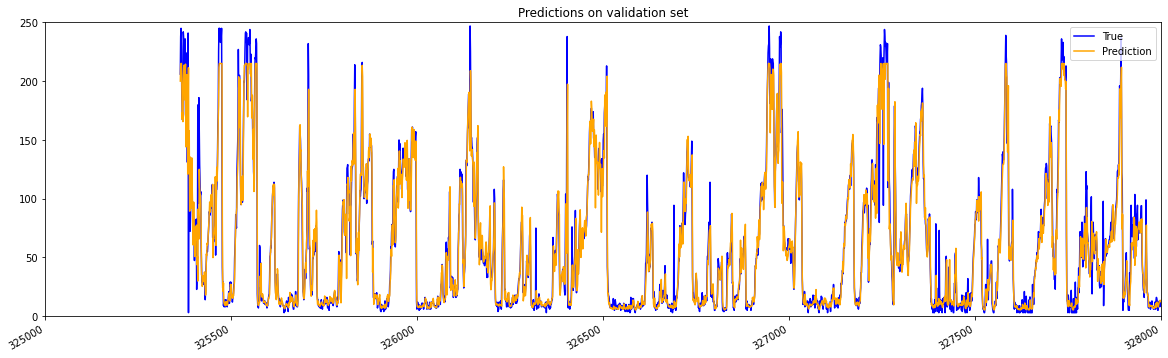

In [15]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(valid.iloc[CFG.seq_length:].index, valid_targets, color='b', label='True')
ax.plot(valid.iloc[CFG.seq_length:].index, valid_predictions, color='orange', label='Prediction')

ax.set_title("PM2.5", fontweight="bold", size=16)
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([325000, 328000, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on validation set')
plt.show()

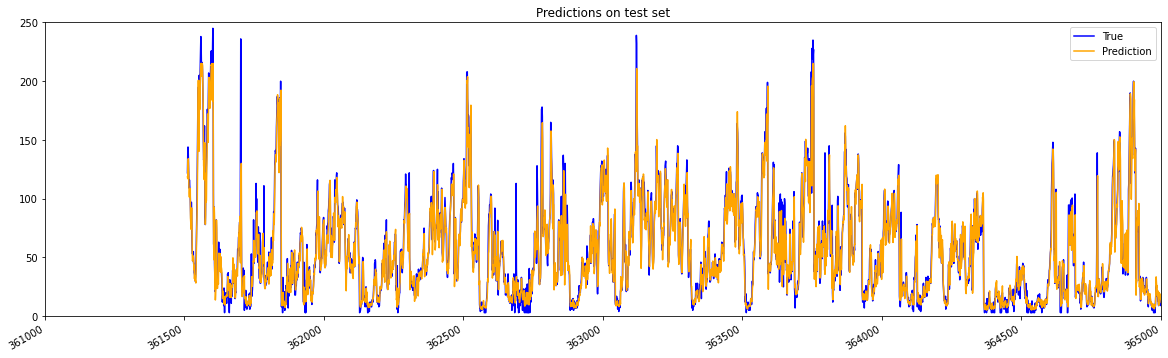

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(test.iloc[CFG.seq_length:].index, test_targets, color='b', label='True')
ax.plot(test.iloc[CFG.seq_length:].index, test_preds, color='orange', label='Prediction')

ax.set_title("PM2.5", fontweight="bold", size=16)
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([361000, 365000, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on test set')
plt.show()